#importing Libraries

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, optimizers
import tensorflow as tf
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.applications import ResNet50,VGG16,ResNet101, VGG19, DenseNet201, EfficientNetB4, MobileNetV2
from tensorflow.keras.applications import resnet, vgg16 , vgg19, densenet, efficientnet, mobilenet_v2
from tensorflow.keras import Model
from tensorflow.keras.optimizers.legacy import Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL
import os
import cv2

In [2]:
train_path = "/content/drive/MyDrive/Data/train"
valid_path = "/content/drive/MyDrive/Data/valid"
test_path = "/content/drive/MyDrive/Data/test"

#Images for the dataset

In [3]:
IMAGE_SIZE = 224
N_CLASSES = 4
BATCH_SIZE = 32
CHANNELS=1
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

train_datagen = ImageDataGenerator( rescale= 1./255.,preprocessing_function = preprocess_input,
    rotation_range = 10,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    shear_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    dtype = 'float32')
train_generator = tf.keras.preprocessing.image_dataset_from_directory(train_path,
                                                       shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    color_mode = "grayscale")

valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
valid_generator = tf.keras.preprocessing.image_dataset_from_directory(valid_path,
                                                       shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    color_mode = "grayscale")

test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = tf.keras.preprocessing.image_dataset_from_directory(test_path,
                                                       shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    color_mode = "grayscale")

Found 613 files belonging to 4 classes.
Found 72 files belonging to 4 classes.
Found 315 files belonging to 4 classes.


In [4]:
test_class_names = test_generator.class_names

#Types of lung cancer color images

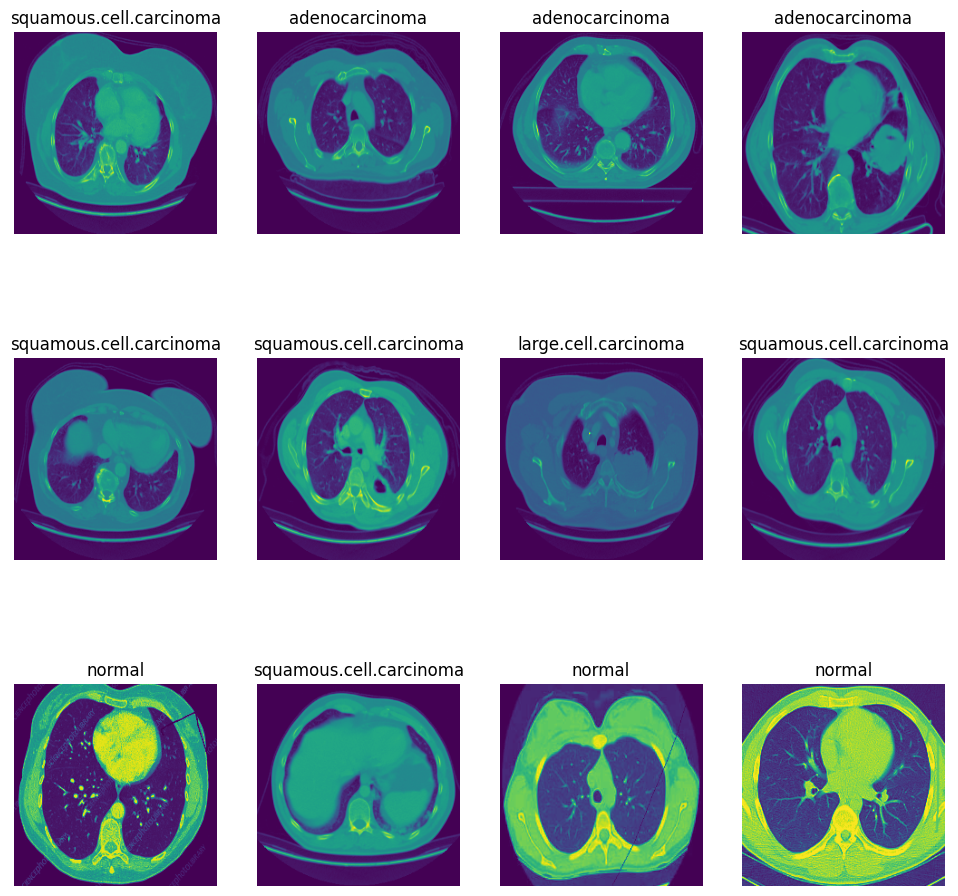

In [5]:
plt.figure(figsize=(12,12))
for image_batch, label_batch in test_generator.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(test_class_names[label_batch[i]])
        plt.axis("off")

In [6]:
train_generator = train_generator.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_generator = test_generator.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_generator = valid_generator.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
from tensorflow.keras import layers, models

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [8]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

#CNN (Convolutional Neural Network) model

In [9]:
base_hidden_units = 8
weight_decay = 1e-3
model = models.Sequential([

    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(N_CLASSES, activation='softmax'),

])
model.build(input_shape=input_shape)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (32, 224, 224, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 222, 222, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 111, 111, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 109, 109, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 54, 54, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 52, 52, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 26, 26, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 24, 24, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 12, 12, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 36864)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │       2,359,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 4)                     │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,747,460 (10.48 MB)

 Trainable params: 2,747,460 (10.48 MB)

 Non-trainable params: 0 (0.00 B)

#Evaluation

In [10]:
checkpointer = ModelCheckpoint('chestmodel.keras',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 15)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
, optimizer= "adam", metrics=['acc'])
history = model.fit(train_generator,
                    epochs = 50,
                    batch_size=BATCH_SIZE,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.2825 - loss: 23.1468
Epoch 1: val_loss improved from inf to 1.35197, saving model to chestmodel.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 171s 5s/step - acc: 0.2834 - loss: 22.5546 - val_acc: 0.3750 - val_loss: 1.3520
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.3672 - loss: 1.3441
Epoch 2: val_loss did not improve from 1.35197
20/20 ━━━━━━━━━━━━━━━━━━━━ 124s 5s/step - acc: 0.3668 - loss: 1.3433 - val_acc: 0.1806 - val_loss: 1.3991
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - acc: 0.3148 - loss: 1.2956
Epoch 3: val_loss improved from 1.35197 to 1.34779, saving model to chestmodel.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 147s 5s/step - acc: 0.3172 - loss: 1.2952 - val_acc: 0.4028 - val_loss: 1.3478
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.3778 - loss: 1.2827
Epoch 4: val_loss improved from 1.34779 to 1.26427, saving model to chestmodel.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - acc: 0.3787 - loss: 1.2823 - 

In [11]:
result = model.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - acc: 0.3741 - loss: 4.8408


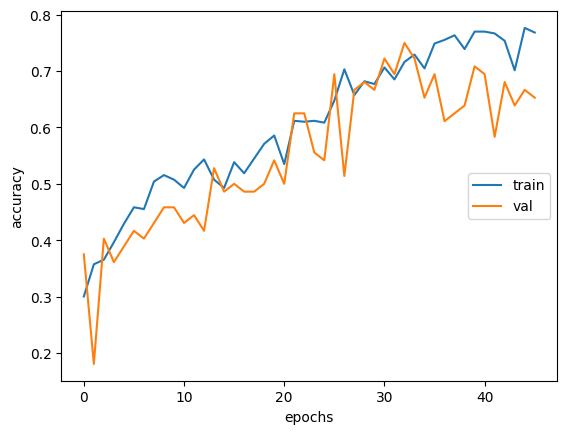

In [12]:
plt.plot(history.history['acc'], label = 'train',)
plt.plot(history.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

first image to predict
actual label: adenocarcinoma
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
predicted label: squamous.cell.carcinoma


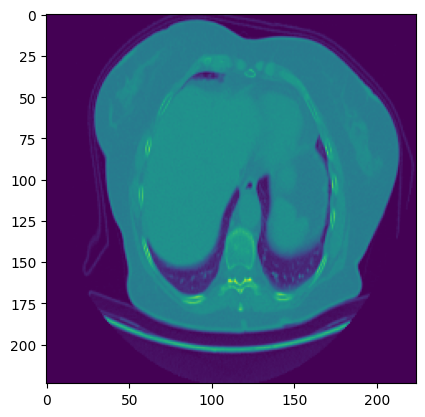

In [13]:
for images_batch, labels_batch in test_generator.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)

    print("actual label:", test_class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:", test_class_names[np.argmax(batch_prediction[0])])

In [14]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch

    predictions = model.predict(img_array)

    predicted_class = test_class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


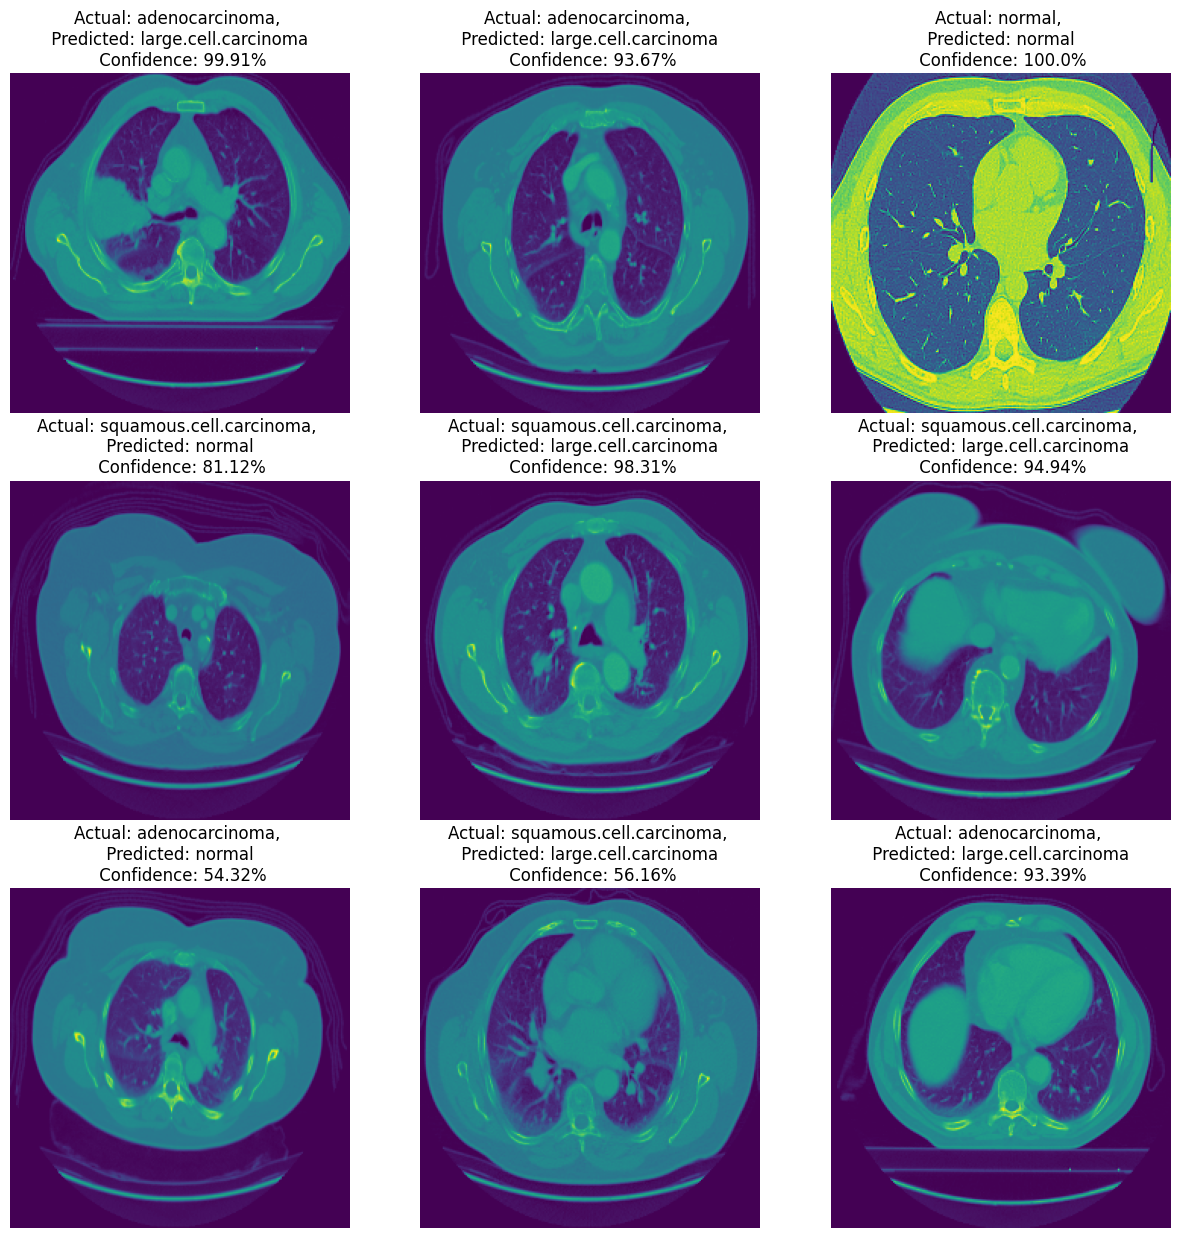

In [15]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = test_class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class} \n Confidence: {confidence}%")

        plt.axis("off")

#EfficientNetB0

In [16]:
train_datagen = train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [17]:
from tensorflow.keras.applications import EfficientNetB0
base_model = EfficientNetB0(input_shape = (350,350,3),
                         include_top = False,
                         weights = 'imagenet')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

early_stopping = EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True, mode='max')

In [19]:
#Customize our base model
EffNetmodel = base_model.output
EffNetmodel = tf.keras.layers.GlobalAveragePooling2D()(EffNetmodel)

# overfitting problem
EffNetmodel = tf.keras.layers.Dropout(rate=0.5)(EffNetmodel)

EffNetmodel = tf.keras.layers.Dense(4,activation='softmax')(EffNetmodel)

In [20]:

EffNetmodel = tf.keras.models.Model(inputs=base_model.input, outputs = EffNetmodel)

EffNetmodel.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [21]:
EffNetB0 = EffNetmodel.fit(
    train_generator,
    steps_per_epoch = train_generator.samples//train_generator.batch_size,
    epochs = 32,
    validation_data = valid_generator,
    validation_steps = valid_generator.samples//valid_generator.batch_size,
    callbacks = [reduce_lr, early_stopping]
    )

Epoch 1/32


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 512s 4s/step - accuracy: 0.4957 - loss: 1.1745 - val_accuracy: 0.2143 - val_loss: 5.3578 - learning_rate: 0.0010
Epoch 2/32


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate
  current = self.get_monitor_value(logs)


  1/122 ━━━━━━━━━━━━━━━━━━━━ 8:51 4s/step - accuracy: 1.0000 - loss: 0.3562

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 1.0000 - loss: 0.3562 - val_accuracy: 0.0000e+00 - val_loss: 8.2726 - learning_rate: 0.0010
Epoch 3/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6813 - loss: 0.8091
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
122/122 ━━━━━━━━━━━━━━━━━━━━ 437s 4s/step - accuracy: 0.6812 - loss: 0.8092 - val_accuracy: 0.2000 - val_loss: 1.8023 - learning_rate: 0.0010
Epoch 4/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 1.0000 - loss: 0.2231 - val_accuracy: 0.5000 - val_loss: 1.0489 - learning_rate: 3.0000e-04
Epoch 5/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 433s 4s/step - accuracy: 0.7357 - loss: 0.6183 - val_accuracy: 0.2143 - val_loss: 2.9553 - learning_rate: 3.0000e-04
Epoch 6/32
  1/122 ━━━━━━━━━━━━━━━━━━━━ 5:36 3s/step - accuracy: 0.8000 - loss: 0.7911
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8000 - loss: 0.7911 -

In [22]:
# Checking the Accuracy of the Model
accuracy_effnet = EffNetmodel.evaluate(test_generator)

63/63 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8532 - loss: 0.4262


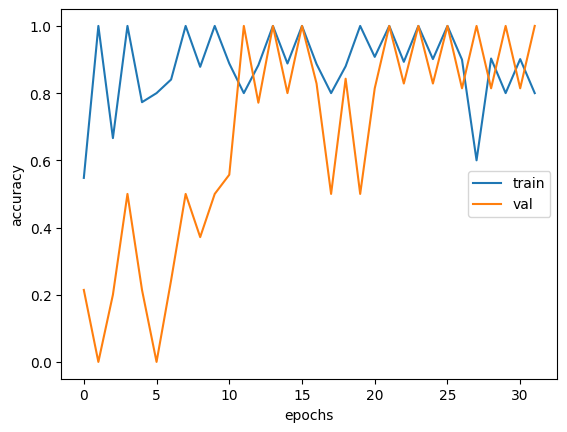

In [23]:
plt.plot(EffNetB0.history['accuracy'], label = 'train',)
plt.plot(EffNetB0.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [24]:
from tensorflow.keras.preprocessing import image

def chestScanPrediction(path, _model, actual_label):
    classes_dir = ["Adenocarcinoma", "Large cell carcinoma", "Normal", "Squamous cell carcinoma"]
    num_images = len(paths)
    for i in range(num_images):
        # Loading Image
        img = image.load_img(paths[i], target_size=(350, 350))

        # Normalizing Image
        norm_img = image.img_to_array(img) / 255

        # Converting Image to Numpy Array
        input_arr_img = np.array([norm_img])

        # Getting Predictions
        pred = np.argmax(_model.predict(input_arr_img))

        # Printing Model Prediction
        print("Predicted Label:", classes_dir[pred])
        print("Actual Label:", classes_dir[actual_label[i]])

        # Displaying the image
        plt.imshow(img)
        plt.title("Actual Label: " + classes_dir[actual_label[i]] + "\nPredicted Label: " + classes_dir[pred])
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Label: Large cell carcinoma
Actual Label: Large cell carcinoma


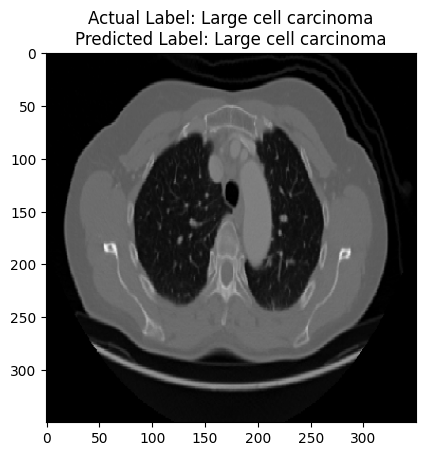

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Predicted Label: Adenocarcinoma
Actual Label: Adenocarcinoma


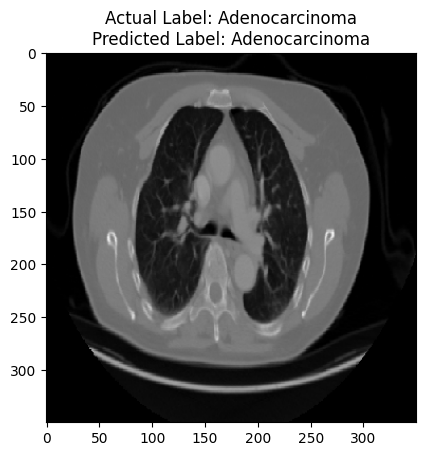

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Predicted Label: Normal
Actual Label: Normal


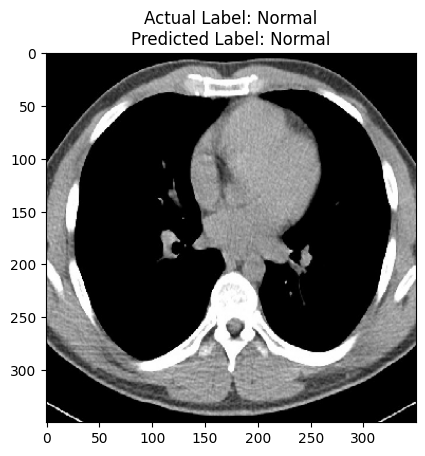

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Predicted Label: Squamous cell carcinoma
Actual Label: Squamous cell carcinoma


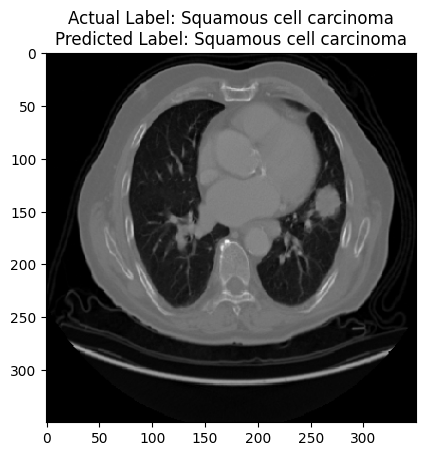

In [26]:
paths = [
    "/content/drive/MyDrive/Data/test/large.cell.carcinoma/000128.png",
    "/content/drive/MyDrive/Data/test/adenocarcinoma/000114.png",
    "/content/drive/MyDrive/Data/test/normal/21.png",
    "/content/drive/MyDrive/Data/test/squamous.cell.carcinoma/000119.png"
]

actual_labels = [1, 0, 2, 3]

chestScanPrediction(paths, EffNetmodel, actual_labels)

#Compare the accuracy value for CNN and EfficientNetB0 models

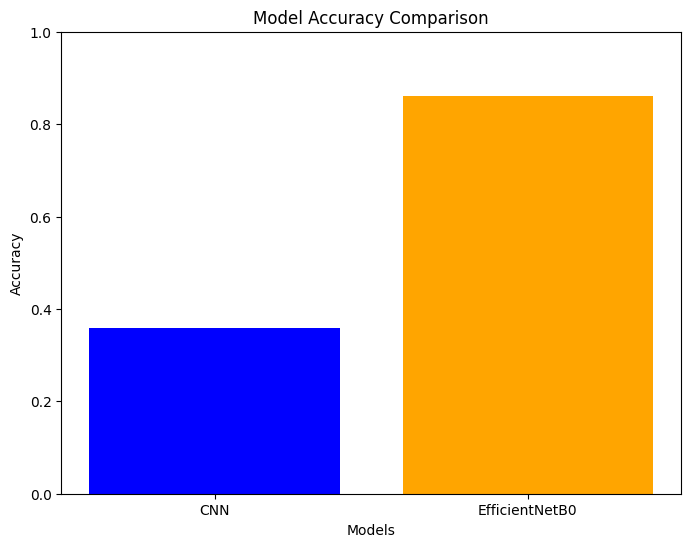

In [27]:
import matplotlib.pyplot as plt
import numpy as np


accuracy_cnn = result[1]
accuracy_effnet = accuracy_effnet[1]

# Bar graph comparison for accuracy
models = ['CNN', 'EfficientNetB0']
accuracies = [accuracy_cnn, accuracy_effnet]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'orange'])
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()


#CNN classification report

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Example of a basic CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(350, 350, 1)),  # Grayscale images
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the output before passing into Dense layers
    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(4, activation='softmax')  # 4 classes in your dataset
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




# Function to calculate sensitivity and specificity
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)  # True Positive Rate
    specificity = tn / (tn + fp)  # True Negative Rate
    return sensitivity, specificity

# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Modify the test generator to load images in grayscale
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Data/test',
    target_size=(350, 350),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# Evaluate CNN model
cnn_y_true = test_generator.classes
cnn_y_pred_probs = model.predict(test_generator)
cnn_y_pred = np.argmax(cnn_y_pred_probs, axis=1)

# Get classification report and confusion matrix for CNN
print("CNN Classification Report:")
print(classification_report(cnn_y_true, cnn_y_pred, target_names=test_class_names))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 315 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step
CNN Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.25      0.23      0.24       120
   large.cell.carcinoma       0.23      0.10      0.14        51
                 normal       0.00      0.00      0.00        54
squamous.cell.carcinoma       0.29      0.56      0.38        90

               accuracy                           0.26       315
              macro avg       0.19      0.22      0.19       315
           weighted avg       0.21      0.26      0.22       315



#CNN confusion matrix

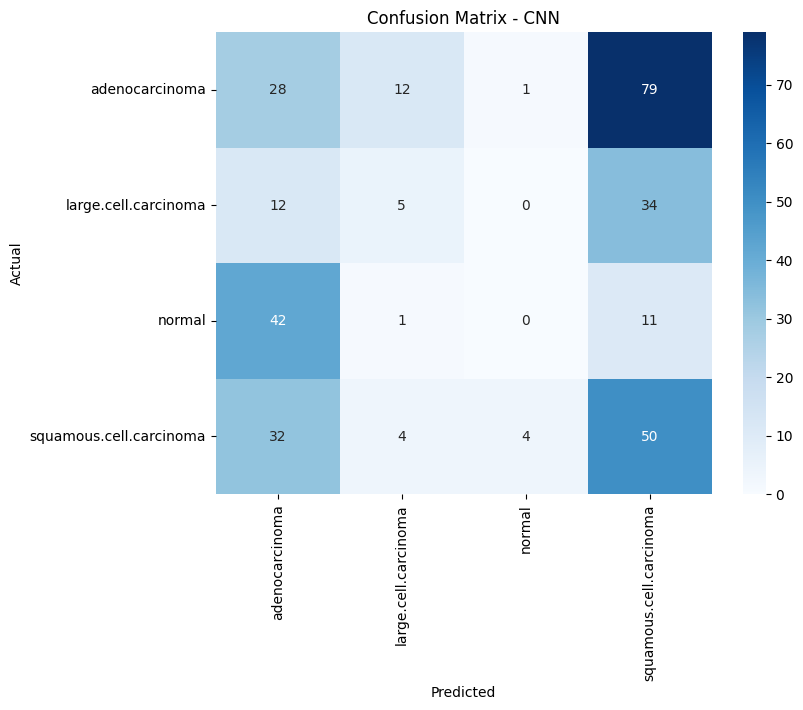

In [54]:
# Plot Confusion Matrix for CNN
cm_cnn = confusion_matrix(cnn_y_true, cnn_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=test_class_names, yticklabels=test_class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - CNN')
plt.show()


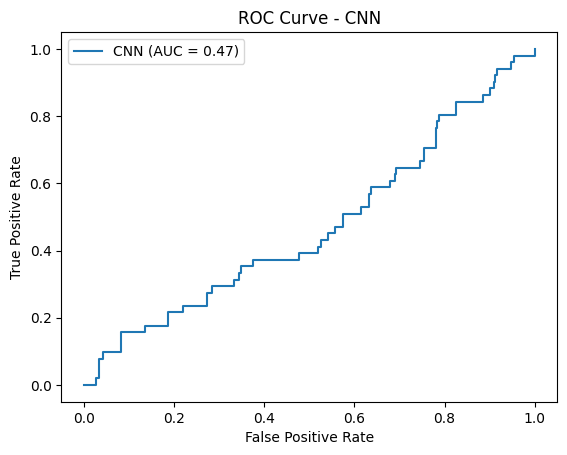

In [55]:
# Plot ROC Curve for CNN
plot_roc_curve(cnn_y_true, cnn_y_pred_probs, 'CNN')  # Use full probabilities for ROC
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CNN')
plt.legend()
plt.show()

#EfficientNetB0 classificatio  report

In [57]:
# Evaluate EfficientNetB0 model

valid_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values to [0, 1]
valid_generator = valid_datagen.flow_from_directory(
    '/content/drive/MyDrive/Data/valid',  # Replace with your validation data directory
    target_size=(350, 350),
    color_mode='rgb',  # Use 'rgb' for EfficientNetB0
    class_mode='categorical',  # Adjust based on your classes
    batch_size=32,
    shuffle=False
)

effnet_y_true = valid_generator.classes
effnet_y_pred_probs = EffNetmodel.predict(valid_generator)  # Predictions
effnet_y_pred = np.argmax(effnet_y_pred_probs, axis=1)  # Predicted classes

# Get classification report and confusion matrix for EfficientNetB0
print("EfficientNetB0 Classification Report:")
print(classification_report(effnet_y_true, effnet_y_pred, target_names=test_class_names))





Found 72 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step
EfficientNetB0 Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.86      0.78      0.82        23
   large.cell.carcinoma       0.88      0.71      0.79        21
                 normal       1.00      1.00      1.00        13
squamous.cell.carcinoma       0.67      0.93      0.78        15

               accuracy                           0.83        72
              macro avg       0.85      0.86      0.85        72
           weighted avg       0.85      0.83      0.83        72



#EfficientNetB0 confusion matrix

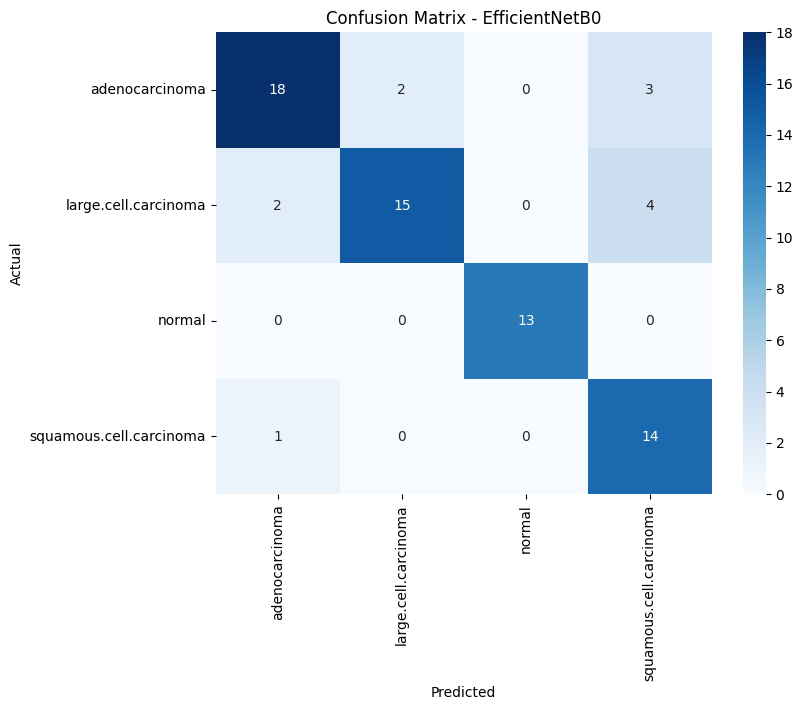

In [58]:
# Plot Confusion Matrix for EfficientNetB0
cm_effnet = confusion_matrix(effnet_y_true, effnet_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_effnet, annot=True, fmt='d', cmap='Blues', xticklabels=test_class_names, yticklabels=test_class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - EfficientNetB0')
plt.show()

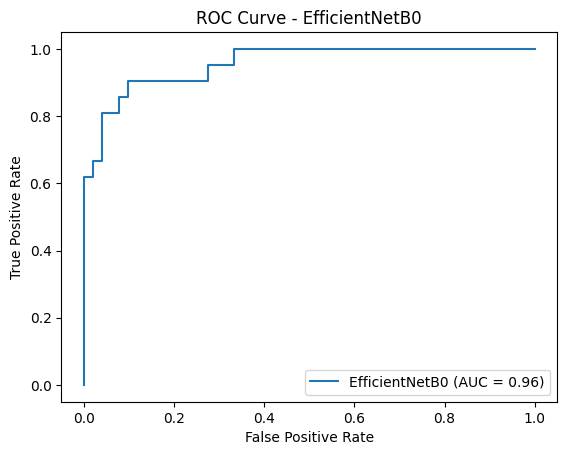

In [59]:
# Plot ROC Curve for EfficientNetB0
plot_roc_curve(effnet_y_true, effnet_y_pred_probs, 'EfficientNetB0')  # Use full probabilities for ROC
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - EfficientNetB0')
plt.legend()
plt.show()



#ROC curve for the both models

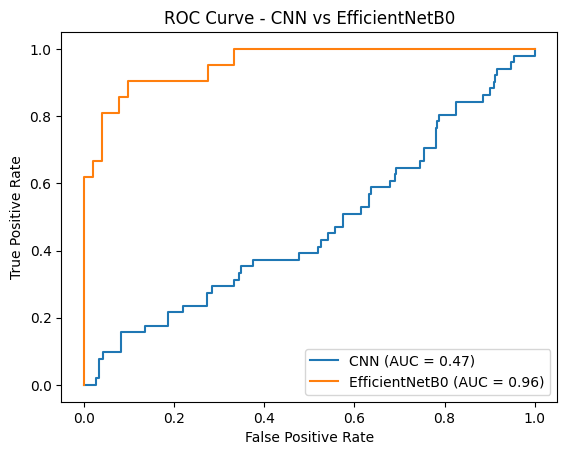

In [60]:
# Final plot for both models in one ROC curve
plt.figure()
plot_roc_curve(cnn_y_true, cnn_y_pred_probs, 'CNN')  # Use full probabilities for ROC
plot_roc_curve(effnet_y_true, effnet_y_pred_probs, 'EfficientNetB0')  # Use full probabilities for ROC
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CNN vs EfficientNetB0')
plt.legend()
plt.show()

#Speficity, sensitivity, accuracy value for both models (CNN,EfficientNetb0)

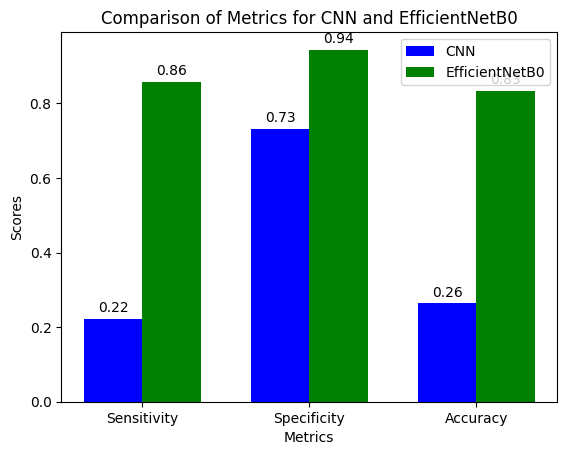

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to calculate sensitivity, specificity, and accuracy for multi-class
def calculate_multiclass_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]

    sensitivity = []
    specificity = []
    accuracy = np.trace(cm) / np.sum(cm)  # Overall accuracy

    for i in range(num_classes):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - (tp + fn + fp)

        sensitivity_i = tp / (tp + fn) if (tp + fn) != 0 else 0
        specificity_i = tn / (tn + fp) if (tn + fp) != 0 else 0

        sensitivity.append(sensitivity_i)
        specificity.append(specificity_i)

    return np.mean(sensitivity), np.mean(specificity), accuracy  # Averaging sensitivity and specificity across classes

# CNN predictions (assuming cnn_y_true and cnn_y_pred are calculated)
cnn_sensitivity, cnn_specificity, cnn_accuracy = calculate_multiclass_metrics(cnn_y_true, cnn_y_pred)

# EfficientNetB0 predictions (assuming effnet_y_true and effnet_y_pred are calculated)
effnet_sensitivity, effnet_specificity, effnet_accuracy = calculate_multiclass_metrics(effnet_y_true, effnet_y_pred)

# Plotting Bar Graph

# Data for bar graph
labels = ['Sensitivity', 'Specificity', 'Accuracy']
cnn_values = [cnn_sensitivity, cnn_specificity, cnn_accuracy]
effnet_values = [effnet_sensitivity, effnet_specificity, effnet_accuracy]

x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of the bars

# Plotting the bar graph
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, cnn_values, width, label='CNN', color='blue')
bars2 = ax.bar(x + width/2, effnet_values, width, label='EfficientNetB0', color='green')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics for CNN and EfficientNetB0')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Display bar values on top of bars
def add_values(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

add_values(bars1)
add_values(bars2)

plt.show()


#Save the best model

In [64]:
# Save the best model based on accuracy


cnn_acc = cnn_accuracy  # CNN model accuracy
effnet_acc = effnet_accuracy  # EfficientNetB0 model accuracy

# Save the best model based on accuracy
if effnet_acc > cnn_acc:
    EffNetmodel.save('best_model_effinetb0.h5')
    print(f"EfficientNetB0 is the best model with accuracy {effnet_acc:.2f} and has been saved as 'best_model_effinetb0.h5'.")
else:
    model.save('best_model_cnn.h5')
    print(f"CNN is the best model with accuracy {cnn_acc:.2f} and has been saved as 'best_model_cnn.h5'.")



EfficientNetB0 is the best model with accuracy 0.83 and has been saved as 'best_model_effinetb0.h5'.
